In [1]:
from typing import AsyncIterable, TypeVar, Any, Iterable, Awaitable
import pure_cv as vc
import haskellian.either as E
import haskellian.asyn as hka
import haskellian.iterables
from moveread.annotations.images import ImageMeta
from moveread.sdk import MovereadAPI
from moveread.bulk_extraction.scripts import extract, transfer, ExtractMeta
from moveread.core import Game, CoreAPI, Image, ImageID, ops
from moveread.export.images import boxes

In [3]:
input = MovereadAPI.at('/home/m4rs/.core/llobregat23/')
output = MovereadAPI.at('../../.data/extr-output')
a_games = [
  game.value
  for game in await input.games.list()
  if E.is_right(game) and game.value.startswith('a')
][:2]

In [ ]:
async for x in extract(a_games, input, output, modelId='llobregat23'):
  ...

In [4]:
result = MovereadAPI.at('../../.data/extr-result')
for gameId in a_games:
  game = (await input.games.read(gameId)).unsafe()
  (await result.core.games.insert(gameId, game, replace=True)).unsafe()

for gameId in a_games:
  game = (await output.games.read(gameId)).unsafe()
  for id, image in ops.images(game):
    image.meta = image.meta or {}
    if 'robust_extract_result' in image.meta and image.meta['robust_extract_result']['tag'] == 'right':
      image.meta['robust_extraction'] = 'correct' if id.player == 0 else 'perspective-correct'
    image.meta['what'] = 'yeah'
  (await output.core.games.update(gameId, game)).unsafe()

In [5]:
await transfer(a_games, output, result)

ImageID(gameId='a/1/1', player=0, page=0, version=0)None
ImageID(gameId='a/1/1', player=0, page=0, version=1)correct
ImageID(gameId='a/1/1', player=1, page=0, version=0)None
ImageID(gameId='a/1/1', player=1, page=0, version=1)perspective-correct
ImageID(gameId='a/1/10', player=0, page=0, version=0)None
ImageID(gameId='a/1/10', player=0, page=1, version=0)correct
ImageID(gameId='a/1/10', player=1, page=0, version=0)None
ImageID(gameId='a/1/10', player=1, page=1, version=0)perspective-correct


In [6]:
game = (await result.games.read('a/1/1')).unsafe()
image = game.players[0].sheets[0].images[-1]

In [7]:
image.meta.keys()

dict_keys(['robust_extraction', 'source', 'what', 'box_contours'])

In [8]:
bs = (await boxes(image, api=result.core)).unsafe()

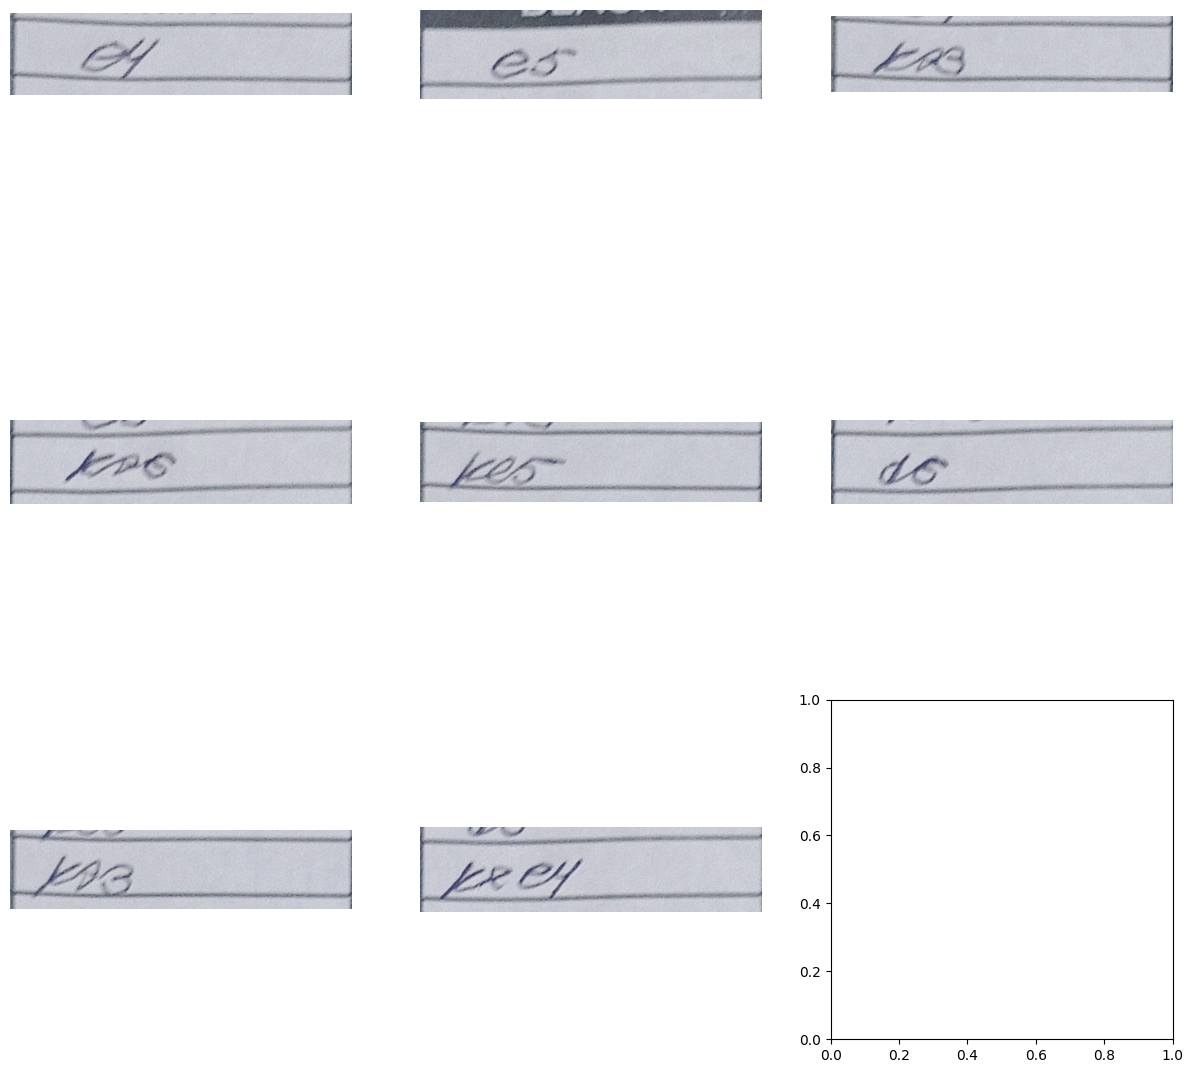

In [9]:
vc.show(*bs[:8])